In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.interpolate import Rbf

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'#'

start @ Fri Oct 22 12:38:50 2021#


In [3]:
print katcali.__version__

0.3.1


In [4]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
fname='1614484873'
if fname=='1614484873':
    data = katdal.open('/idia/projects/hi_im/SCI-20190418-MS-01/1614484873-autos/1614484873/1614484873_sdp_l0.full.rdb')

In [6]:
print data

Name: file:///idia/projects/hi_im/SCI-20190418-MS-01/1614484873-autos/1614484873/1614484873_sdp_l0.full.rdb | 1614484873-sdp-l0 (version 4.0)
Observer: Benjamin Hugo  Experiment ID: 20210226-0016
Description: 'RARG engineering: autocorrelation calibration test'
Observed from 2021-02-28 06:01:30.757 SAST to 2021-02-28 06:35:59.881 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m008,m009,m010,m011,m012,m013,m014,m015,m016,m017,m018,m019,m020,m021,m022,m023,m024,m025,m026,m027,m028,m029,m030,m031,m032,m034,m035,m036,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m052,m053,m054,m055,m056,m057,m058,m059,m060,m061,m062,m063  126      252
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
---------------------------------------

In [7]:
data.obs_script_log

['2021-02-28 04:01:12.889Z INFO     ==========================',
 '2021-02-28 04:01:12.890Z INFO     New data capturing session',
 '2021-02-28 04:01:12.890Z INFO     --------------------------',
 "2021-02-28 04:01:12.890Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-02-28 04:01:12.891Z INFO     CBF instruments and streams:',
 "2021-02-28 04:01:12.891Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-02-28 04:01:12.891Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-02-28 04:01:12.892Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-02-28 04:01:12.892Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-02-28 04:01:12.892Z INFO     SD

In [8]:
ant='m000'
pol='h'
recv=ant+pol


In [9]:
data.select(ants=ant)
print np.shape(data.vis)
data.select()

(1035, 4096, 4)


In [10]:
data.select(ants=ant,pol=pol,scans='track')
dp_t=data.dumps
print np.shape(dp_t)
data.select()

data.select(ants=ant,pol=pol)
print np.shape(data.vis)
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)


(993,)
(1035, 4096, 1)


In [11]:
vis_matrix=data.vis[:,:,:]
assert(np.shape(vis_matrix)[2])==1 
vis=vis_matrix[:,:,0].real
print np.shape(vis)
flags=data.flags
vis_backup=vis.copy()
print np.shape(vis)

(1035, 4096)
(1035, 4096)


In [12]:
print vis_matrix

[[[ 1593.28344727+0.j]
  [   49.02909851+0.j]
  [   49.06164932+0.j]
  ..., 
  [    0.00000000+0.j]
  [    0.00000000+0.j]
  [    0.00000000+0.j]]

 [[ 1593.19470215+0.j]
  [   49.05703354+0.j]
  [   49.03352737+0.j]
  ..., 
  [   75.68847656+0.j]
  [   76.06445312+0.j]
  [   77.03244781+0.j]]

 [[ 1591.69262695+0.j]
  [   49.13543320+0.j]
  [   49.17597580+0.j]
  ..., 
  [   75.78733826+0.j]
  [   76.15992737+0.j]
  [   77.55350494+0.j]]

 ..., 
 [[ 1628.91247559+0.j]
  [   50.33228683+0.j]
  [   50.29164886+0.j]
  ..., 
  [   76.23934937+0.j]
  [   76.75883484+0.j]
  [   77.87708282+0.j]]

 [[ 1630.19726562+0.j]
  [   50.26483154+0.j]
  [   50.25271606+0.j]
  ..., 
  [   76.41163635+0.j]
  [   76.63421631+0.j]
  [   77.73481750+0.j]]

 [[ 1631.00634766+0.j]
  [   50.59283829+0.j]
  [   50.19987106+0.j]
  ..., 
  [   76.35801697+0.j]
  [   76.76340485+0.j]
  [   77.83745575+0.j]]]


In [13]:
print vis

[[ 1593.28344727    49.02909851    49.06164932 ...,     0.             0.
      0.        ]
 [ 1593.19470215    49.05703354    49.03352737 ...,    75.68847656
     76.06445312    77.03244781]
 [ 1591.69262695    49.1354332     49.1759758  ...,    75.78733826
     76.15992737    77.55350494]
 ..., 
 [ 1628.91247559    50.33228683    50.29164886 ...,    76.23934937
     76.75883484    77.87708282]
 [ 1630.19726562    50.26483154    50.25271606 ...,    76.41163635
     76.63421631    77.7348175 ]
 [ 1631.00634766    50.59283829    50.19987106 ...,    76.35801697
     76.76340485    77.83745575]]


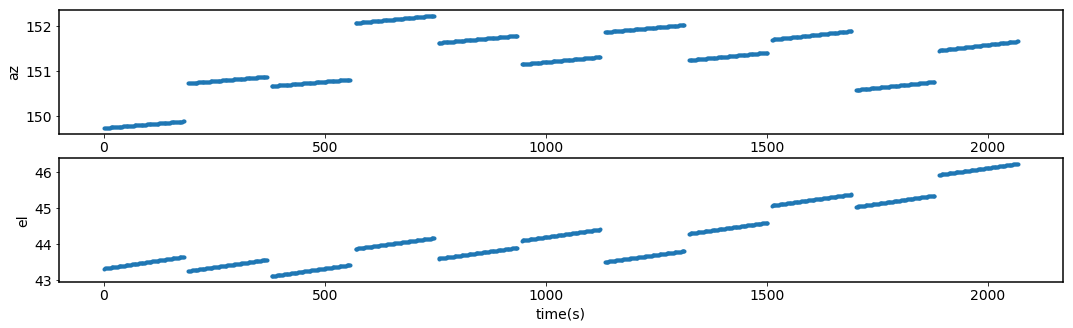

In [14]:
plt.figure(figsize=(18,5))
plt.subplot(211)
plt.plot(timestamps[dp_t]-timestamps[0], az[dp_t], '.')
#plt.xlabel('time(s)')
plt.ylabel('az')
plt.subplot(212)
plt.plot(timestamps[dp_t]-timestamps[0], el[dp_t], '.')
plt.xlabel('time(s)')
plt.ylabel('el')
plt.show()

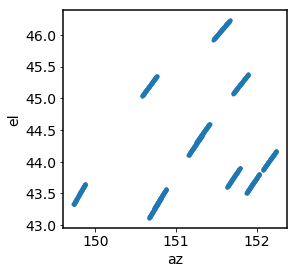

In [15]:
plt.figure(figsize=(4,4))
plt.plot(az[dp_t],el[dp_t],'.')
plt.xlabel('az')
plt.ylabel('el')
plt.show()

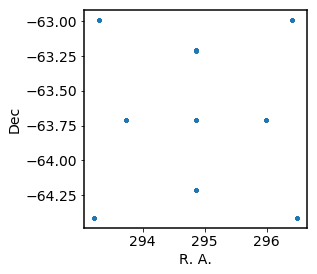

In [16]:
plt.figure(figsize=(4,4))
plt.plot(ra[dp_t],dec[dp_t],'.')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

In [17]:
data1 = pickle.load(open('/idia/projects/hi_im/raw_vis/'+str(fname)+'/'+str(fname)+'_'+str(recv)+'_vis_data','rb'))
vis1=data1['vis']

In [18]:
diff=vis-vis1
print np.min(diff), np.max(diff)

-1838.40365601 10084.1650085


In [19]:
a=np.where(diff!=0)

In [20]:
print a

(array([ 584,  584,  584, ..., 1022, 1022, 1022]), array([ 329,  330,  331, ..., 2301, 2302, 2303]))


In [21]:
print vis[a],vis1[a]

[ 306.49127197  306.7666626   306.43411255 ...,  235.6857605   235.14137268
  235.72067261] [ 319.28396606  317.81338501  318.65835571 ...,  265.35253906  264.56298828
  263.37237549]


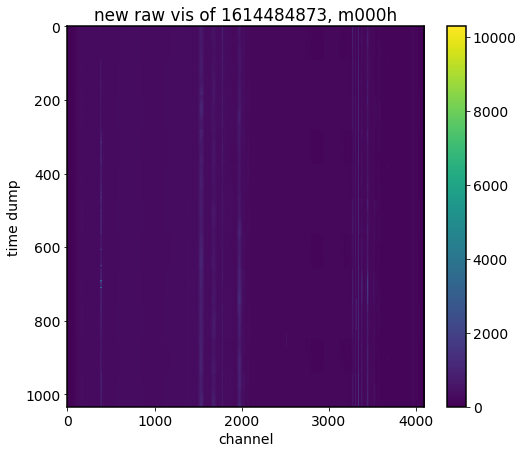

In [22]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('new raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

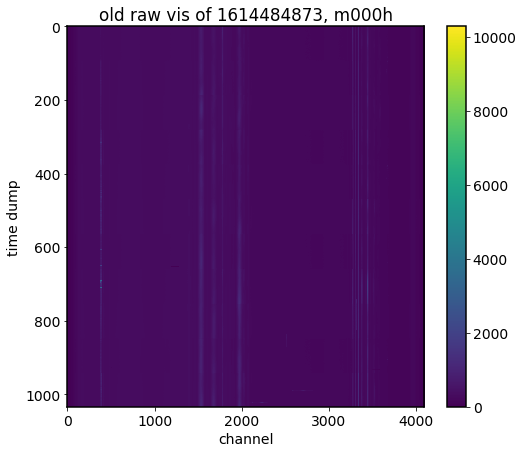

In [23]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis1,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('old raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [24]:
diff1=np.ma.array(diff,mask=False)
diff1.mask[np.where(diff1==0)]=True

In [25]:
diff1

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

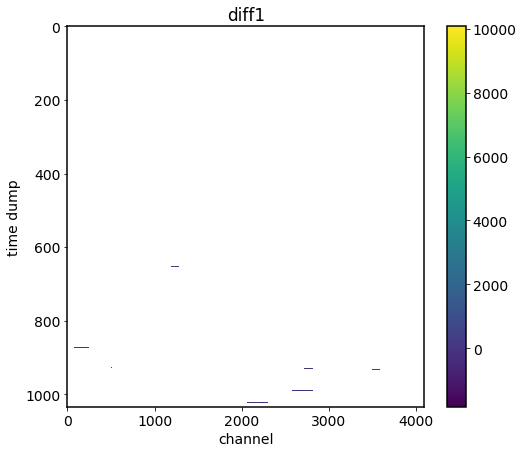

In [26]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(diff1,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('diff1')
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

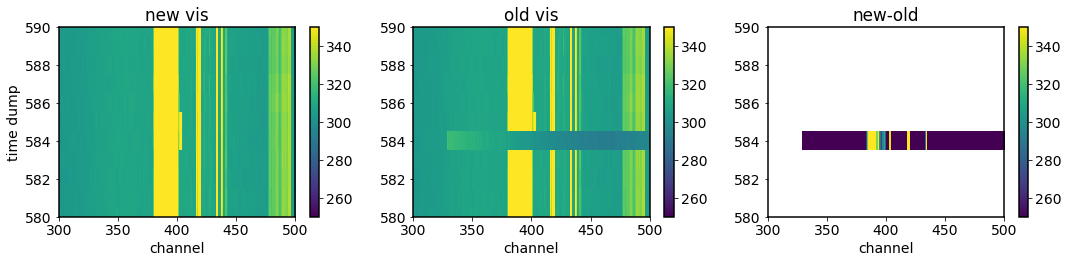

In [27]:
plt.figure(figsize=(18,3.5))
plt.subplot(131)
plt.imshow(vis,aspect='auto',vmin=250,vmax=350)
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('new vis')
plt.xlim(300,500)
plt.ylim(580,590)
plt.colorbar()
plt.subplot(132)
plt.imshow(vis1,aspect='auto',vmin=250,vmax=350)
#plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('old vis')
plt.xlim(300,500)
plt.ylim(580,590)
plt.colorbar()
plt.subplot(133)
plt.imshow(diff1,aspect='auto',vmin=250,vmax=350)
#plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('new-old')
plt.xlim(300,500)
plt.ylim(580,590)
plt.colorbar()
plt.show()

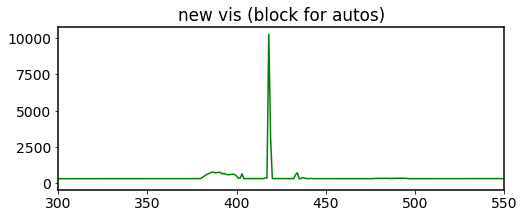

In [28]:
plt.figure(figsize=(8,3))
plt.plot(vis[584,:],'g')
plt.xlim(300,550)
plt.title('new vis (block for autos)')
plt.show()

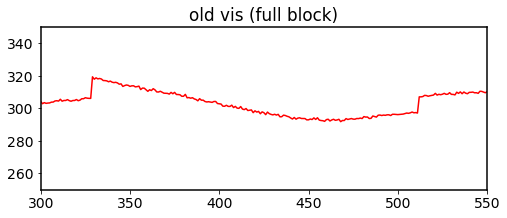

In [29]:
plt.figure(figsize=(8,3))
plt.plot(vis1[584,:],'r')
plt.xlim(300,550)
plt.ylim(250,350)
plt.title('old vis (full block)')
plt.show()

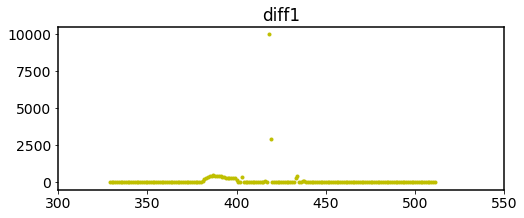

In [30]:
plt.figure(figsize=(8,3))
plt.plot(diff1[584,:],'y.')
plt.xlim(300,550)
plt.title('diff1')
plt.show()

[False False False ..., False False False]
False
[ 0.  0.  0. ...,  0.  0.  0.]


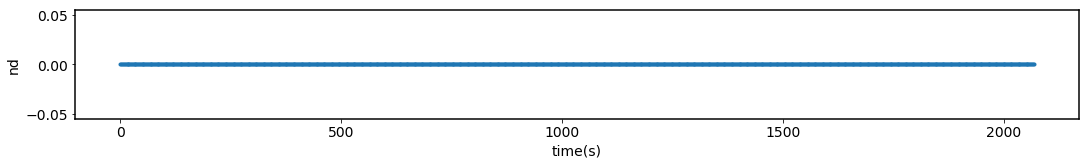

In [31]:
noise_type='coupler'
print data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)]
print (data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)]==True).all()

nd_ratio=data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)].astype(float)
print nd_ratio

plt.figure(figsize=(18,2))
plt.plot(timestamps-timestamps[0], nd_ratio, '.')
plt.xlabel('time(s)')
plt.ylabel('nd')
plt.show()

In [32]:
##check save_data

In [33]:
data.obs_script_log

['2021-02-28 04:01:12.889Z INFO     ==========================',
 '2021-02-28 04:01:12.890Z INFO     New data capturing session',
 '2021-02-28 04:01:12.890Z INFO     --------------------------',
 "2021-02-28 04:01:12.890Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-02-28 04:01:12.891Z INFO     CBF instruments and streams:',
 "2021-02-28 04:01:12.891Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-02-28 04:01:12.891Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-02-28 04:01:12.892Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-02-28 04:01:12.892Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-02-28 04:01:12.892Z INFO     SD

In [34]:
print '#check data shape'
print '-------------------------------------------------'
print '#select all ants'
data.select()
print 'block related parameters:'
print np.shape(data.timestamps),np.shape(data.temperature),np.shape(data.humidity),np.shape(data.pressure)
print 'ant related parameters:'
print np.shape(data.ra),np.shape(data.dec),np.shape(data.az),np.shape(data.el),np.shape(data.parangle)
print '-------------------------------------------------'
print '#select one ant'
data.select(ants=ant)
print 'block related parameters:'
print np.shape(data.timestamps),np.shape(data.temperature),np.shape(data.humidity),np.shape(data.pressure)
print 'ant related parameters:'
print np.shape(data.ra),np.shape(data.dec),np.shape(data.az),np.shape(data.el),np.shape(data.parangle)
print '-------------------------------------------------'

#check data shape
-------------------------------------------------
#select all ants
block related parameters:
(1035,) (1035,) (1035,) (1035,)
ant related parameters:
(1035, 63) (1035, 63) (1035, 63) (1035, 63) (1035, 63)
-------------------------------------------------
#select one ant
block related parameters:
(1035,) (1035,) (1035,) (1035,)
ant related parameters:
(1035, 1) (1035, 1) (1035, 1) (1035, 1) (1035, 1)
-------------------------------------------------


In [35]:
#'''
data.select()
print len(data.timestamps)
data.select(ants=ant,pol=pol)
print len(data.timestamps)
data.select(ants=ant,pol=pol,scans='track')
print len(data.timestamps)
dp_t=data.dumps
print len(dp_t)
#'''

1035
1035
993
993


In [36]:
#'''
data.select()
print len(data.timestamps)
data.select(ants=ant,pol=pol)
print len(data.timestamps)
ss=data.sensor['Antennas/{0}/activity'.format(ant)]
dp_t2= np.where(ss=='track')[0]
print len(dp_t2)
#'''

1035
1035
986


In [37]:
#'''
dp_inter=list(set(dp_t).intersection(set(dp_t2)))
print len(dp_inter)
#'''

983


In [38]:
#'''
dp_diff1=list(set(dp_t)-set(dp_inter))
print len(dp_diff1)
dp_diff2=list(set(dp_t2)-set(dp_inter))
print len(dp_diff2)
#'''

10
3


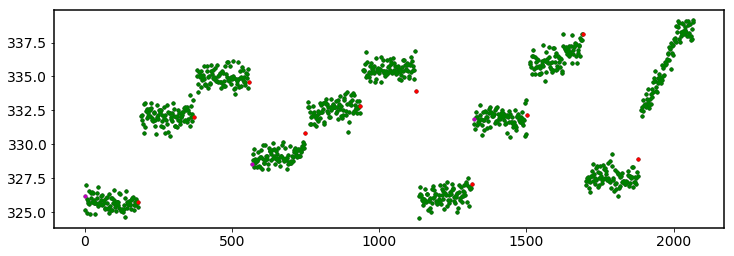

In [39]:
#'''
ch_plot=800
plt.figure(figsize=(12,4))
plt.plot(timestamps[dp_t]-timestamps[0],vis[dp_t,ch_plot],'k.')
plt.plot(timestamps[dp_t2]-timestamps[0],vis[dp_t2,ch_plot],'g.')
plt.plot(timestamps[dp_diff1]-timestamps[0],vis[dp_diff1,ch_plot],'r.')
plt.plot(timestamps[dp_diff2]-timestamps[0],vis[dp_diff2,ch_plot],'m.')
plt.show()
#'''

In [40]:
#start
data2={}

#each block
data.select()
data2['timestamps']=data.timestamps
data2['freqs']=data.freqs
data2['temperature']=data.temperature
data2['humidity']=data.humidity
data2['pressure']=data.pressure
data2['receivers']=data.receivers
data2['obs_script_log']=data.obs_script_log   
data2['header']=data.__str__()
data2['ant_list']=kio.ant_list(data)
#each dish
data.select()
for ant in kio.ant_list(data):
    print ant,
    data.select(ants=ant)
    assert(np.shape(data.ra)[1]==1)
    data2[ant]={
    'ra': data.ra[:,0],    
    'dec':data.dec[:,0],    
    'az':data.az[:,0],
    'el':data.el[:,0],
    'ScanState':data.sensor['Antennas/{0}/activity'.format(ant)], #track
    'nd_ratio':data.sensor['Antennas/{0}/nd_{1}'.format(ant,noise_type)].astype(float),
    'observer_elevation':data.ants[0].observer.elevation,
    'observer_lon_rad':float(data.ants[0].observer.lon),
    'observer_lat_rad':float(data.ants[0].observer.lat)  
    }
d2=kio.RecDictWrapper(data2)

m000 m001 m002 m003 m004 m005 m006 m007 m008 m009 m010 m011 m012 m013 m014 m015 m016 m017 m018 m019 m020 m021 m022 m023 m024 m025 m026 m027 m028 m029 m030 m031 m032 m034 m035 m036 m037 m038 m039 m040 m041 m042 m043 m044 m045 m046 m047 m048 m049 m050 m051 m052 m053 m054 m055 m056 m057 m058 m059 m060 m061 m062 m063


In [41]:
assert((d2.m000.ra==ra).all())
print (d2.m000.ra==ra).all()

True


In [42]:
fs=open(fname+'_para','wb')
pickle.dump(d2,fs,protocol=2)
fs.close()

In [43]:
print '# reload saved data to check'

# reload saved data to check


In [44]:
d3 = pickle.load(open(fname+'_para'))
print d3.keys

['m047', 'm046', 'ant_list', 'm008', 'm043', 'obs_script_log', 'm041', 'm040', 'm003', 'm002', 'm001', 'm000', 'm007', 'm006', 'm005', 'm004', 'header', 'm044', 'm054', 'm059', 'm042', 'm061', 'temperature', 'm009', 'm053', 'm055', 'm036', 'm037', 'm034', 'm035', 'm032', 'm030', 'm031', 'timestamps', 'm038', 'm039', 'm018', 'm019', 'm056', 'm057', 'm050', 'm051', 'm052', 'receivers', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm060', 'pressure', 'm049', 'm048', 'm045', 'm062', 'freqs', 'm063', 'humidity', 'm021', 'm020', 'm023', 'm022', 'm025', 'm024', 'm027', 'm026', 'm029', 'm028', 'm058']


In [45]:
assert((d3.m000.ra==ra).all())
print (d3.m000.ra==ra).all()

True


In [46]:
print d3.header

Name: file:///idia/projects/hi_im/SCI-20190418-MS-01/1614484873-autos/1614484873/1614484873_sdp_l0.full.rdb | 1614484873-sdp-l0 (version 4.0)
Observer: Benjamin Hugo  Experiment ID: 20210226-0016
Description: 'RARG engineering: autocorrelation calibration test'
Observed from 2021-02-28 06:01:30.757 SAST to 2021-02-28 06:35:59.881 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m008,m009,m010,m011,m012,m013,m014,m015,m016,m017,m018,m019,m020,m021,m022,m023,m024,m025,m026,m027,m028,m029,m030,m031,m032,m034,m035,m036,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m052,m053,m054,m055,m056,m057,m058,m059,m060,m061,m062,m063  126      252
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
---------------------------------------

In [47]:
d3.obs_script_log

['2021-02-28 04:01:12.889Z INFO     ==========================',
 '2021-02-28 04:01:12.890Z INFO     New data capturing session',
 '2021-02-28 04:01:12.890Z INFO     --------------------------',
 "2021-02-28 04:01:12.890Z INFO     Session CBF = 'cbf' (1 fengine, 2 beamformers, 1 correlator)",
 '2021-02-28 04:01:12.891Z INFO     CBF instruments and streams:',
 "2021-02-28 04:01:12.891Z INFO       -> 'wide' (1 fengine, 2 beamformers, 1 correlator)",
 "2021-02-28 04:01:12.891Z INFO            -> fengine    'wide.antenna-channelised-voltage' (128 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0y' (64 inputs)",
 "2021-02-28 04:01:12.891Z INFO            -> beamformer 'wide.tied-array-channelised-voltage.0x' (64 inputs)",
 "2021-02-28 04:01:12.892Z INFO            -> correlator 'wide.baseline-correlation-products' (128 inputs)",
 "2021-02-28 04:01:12.892Z INFO     Session SDP = 'sdp' (1 product)",
 '2021-02-28 04:01:12.892Z INFO     SD

In [48]:
data.select()
for ant in d3.ant_list:
    data.select(ants=ant)
    
    assert(data.ants[0].observer.elevation==d3.__getattribute__(ant).observer_elevation)
    assert(data.ants[0].observer.lon==d3.__getattribute__(ant).observer_lon_rad)
    assert(data.ants[0].observer.lat==d3.__getattribute__(ant).observer_lat_rad)
    print ant,
print 'checked'

m000 m001 m002 m003 m004 m005 m006 m007 m008 m009 m010 m011 m012 m013 m014 m015 m016 m017 m018 m019 m020 m021 m022 m023 m024 m025 m026 m027 m028 m029 m030 m031 m032 m034 m035 m036 m037 m038 m039 m040 m041 m042 m043 m044 m045 m046 m047 m048 m049 m050 m051 m052 m053 m054 m055 m056 m057 m058 m059 m060 m061 m062 m063 checked


In [49]:
print '# load old version data to check'

# load old version data to check


In [50]:
d4 = pickle.load(open('/users/jywang/MeerKAT/model_test/calibrator2/'+fname+'_para'))
print d4.keys

['m047', 'm046', 'm009', 'm008', 'm043', 'obs_script_log', 'm041', 'm040', 'm003', 'm002', 'm001', 'm000', 'm007', 'm006', 'm005', 'm004', 'header', 'm044', 'm054', 'm059', 'm042', 'm061', 'temperature', 'm053', 'm055', 'm036', 'm037', 'm034', 'm035', 'm032', 'm030', 'm031', 'timestamps', 'm038', 'm039', 'm018', 'm019', 'm056', 'm057', 'm050', 'm051', 'm052', 'receivers', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm060', 'pressure', 'm049', 'm048', 'm045', 'm062', 'freqs', 'm063', 'humidity', 'm021', 'm020', 'm023', 'm022', 'm025', 'm024', 'm027', 'm026', 'm029', 'm028', 'm058']


In [51]:

assert((d3.temperature==d4.temperature).all())
assert((d3.humidity==d4.humidity).all())
print 'checked'

for ant in d3.ant_list:

    assert(d3.__getattribute__(ant).observer_elevation==d4.__getattribute__(ant).observer_elevation)
    assert((d3.__getattribute__(ant).ra==d4.__getattribute__(ant).ra).all())
    assert((d3.__getattribute__(ant).el==d4.__getattribute__(ant).el).all())
    print ant,
print ''
print 'checked'

checked
m000 m001 m002 m003 m004 m005 m006 m007 m008 m009 m010 m011 m012 m013 m014 m015 m016 m017 m018 m019 m020 m021 m022 m023 m024 m025 m026 m027 m028 m029 m030 m031 m032 m034 m035 m036 m037 m038 m039 m040 m041 m042 m043 m044 m045 m046 m047 m048 m049 m050 m051 m052 m053 m054 m055 m056 m057 m058 m059 m060 m061 m062 m063 
checked


In [52]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Fri Oct 22 12:39:36 2021#
